<h2>Introduction to TensorFlow</h2>
<p>TensorFlow relies on a highly efficient C++ backend to do its computation. The connection to this backend is called a <b>Session</b>. The common usage for TensorFlow programs is to first create a <b>graph</b> and then launch it in a session.</p>

<p>Tensorflow represent computations as graphs. Nodes in the graph are called <b>ops</b> (short for operations). An op takes tensors, performs some computation, and produces tensors. A <b>Tensor</b> is a typed multi-dimensional array. For example, you can represent a mini-batch of images as a 4-D array of floating point numbers with dimensions [batch, height, width, channels].</p>

<p><b>Why use graph?</b> Instead of running a single expensive operation independently from Python, TF allows us to define a graph of interacting operations that run entirely outside Python to avoid the overhead from switching back to Python every operation. The role of the Python code is therefore to build this external computation graph, and to dictate which parts of the computation graph should be run. This approach is similar to that used in Theano or Torch</p>

<p>A TensorFlow graph is a description of computations. To compute anything, a graph must be launched in a Session. A Session places the graph ops onto <b>Devices</b>, such as CPUs or GPUs, and provides methods to execute them. These methods return tensors produced by ops as numpy ndarray objects.</p>
<br>

<h3>Checking Variables</h3>
<p><b>print variable values</b>: print(sess.run(weight1))</p>
<p><b>all variable name</b>: [v.name for v in tf.trainable_variables()]</p>
<br>

<h3>Tensorboard</h3>
<p><b>Initialize Tensorboard</b>: tensorboard --logdir=path/to/logs<b> Or specify another port 8008</b>: tensorboard --logdir=/tmp/mnist_logs_try --port=8008</p>
<p><b>Compare train & test of your model:</b> output event summaries to /train and /test folders under path/to/logs</p>
<p>To get an updated graph representation you should stop tensorboard and jupyter, delete your tensorflow logdir, restart jupyter, run the script, and then restart tensorboard.</p>

In [92]:
import tensorflow as tf
import numpy as np

### Simple Example1 - print out string

In [105]:
summary

<tf.Tensor 'Scope_2/ScalarSummary/TensorSummary:0' shape=() dtype=string>

In [125]:
hello = tf.constant(12345) 
sess = tf.Session() # launch graph
print(sess.run(hello)) 
sess.close() 

12345


### Simple Example2 - matrix multiplication

In [89]:
# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
product = tf.matmul(matrix1, matrix2)

# use 'with' to launch the default graph and close it automatically after use, to release the CPU/GPU resource
# 'run' causes the execution of threes ops in the graph: the two constants and matmul
with tf.Session() as sess:
    result = sess.run(product)
    print(result)

[[ 12.]]


### Simple Example3 - fit a line to some data

In [197]:
def model(inputs):
    W = tf.get_variable('w',shape=[1],initializer=tf.random_normal_initializer())
    b = tf.get_variable('b',shape=[1],initializer=tf.constant_initializer(0.0))
    output = W * inputs + b
    return output, [W, b]

tf.reset_default_graph()

with tf.name_scope('input'):
    # Create 100 phony x, y data points in NumPy, y = x * 0.1 + 0.3
    x_data = np.random.rand(100).astype(np.float32)
    y_data = x_data * 0.1 + 0.3

with tf.variable_scope('generator'):
    y, para = model(x_data)
    
'''   
with tf.name_scope('parameters'):
    # Try to find values for W and b that compute y_data = W * x_data + b
    # (We know that W should be 0.1 and b 0.3, but TensorFlow will
    # figure that out for us.)
    W = tf.Variable(tf.random_uniform([1], -1.0, 1.0), name="weights")
    b = tf.Variable(tf.zeros([1]), name="bias")

with tf.name_scope('estimated_y'):
    y = W * x_data + b
''' 

# Minimize the mean squared errors.
with tf.name_scope('MES_loss'):
    loss = tf.reduce_mean(tf.square(y - y_data))
    # create a summary for loss
    tf.scalar_summary("loss", loss)
    tf.histogram_summary("loss_hist", loss)
with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(0.5).minimize(loss) # train operation

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
with tf.Session() as sess:
    sess.run(init)

    # Instead of executing every summary operation individually we can merge them all together into a single merged summary operation.
    summary_op = tf.merge_all_summaries()
    # Tensorflow summaries are essentially logs. And in order to write logs we need a log writer a SummaryWriter
    writer = tf.train.SummaryWriter("/tmp/tensorboard_example3", graph=tf.get_default_graph())

    # Fit the line.
    for step in range(201):
        #sess.run(train)
        # perform the operations we defined earlier on batch
        # each operation will return the itself, in this case train_op returns None, only keep the returned summary
        _, summary = sess.run([train_op, summary_op])
        
        # write log
        writer.add_summary(summary, step)

        if step % 50 == 0:
            print 'step:',step, ' parameters:', sess.run(para)
# Learns best fit is W: [0.1], b: [0.3]

step: 0  parameters: [array([-0.99870467], dtype=float32), array([ 1.19547927], dtype=float32)]
step: 50  parameters: [array([ 0.06672464], dtype=float32), array([ 0.31739694], dtype=float32)]
step: 100  parameters: [array([ 0.09910019], dtype=float32), array([ 0.30047044], dtype=float32)]
step: 150  parameters: [array([ 0.09997568], dtype=float32), array([ 0.30001274], dtype=float32)]
step: 200  parameters: [array([ 0.09999936], dtype=float32), array([ 0.30000034], dtype=float32)]


In [190]:
tf.reset_default_graph()

with tf.name_scope('input'):
    # Create 100 phony x, y data points in NumPy, y = x * 0.1 + 0.3
    x_data = np.random.rand(100).astype(np.float32)
    y_data = x_data * 0.1 + 0.3

with tf.name_scope('parameters'):
    # Try to find values for W and b that compute y_data = W * x_data + b
    # (We know that W should be 0.1 and b 0.3, but TensorFlow will
    # figure that out for us.)
    W = tf.Variable(tf.random_uniform([1], -1.0, 1.0), name="weights")
    b = tf.Variable(tf.zeros([1]), name="bias")

with tf.name_scope('estimated_y'):
    y = W * x_data + b

# Minimize the mean squared errors.
with tf.name_scope('MES_loss'):
    loss = tf.reduce_mean(tf.square(y - y_data))
    # create a summary for loss
    tf.scalar_summary("loss", loss)
    tf.histogram_summary("loss_hist", loss)
with tf.name_scope('train'):
    train_op = tf.train.GradientDescentOptimizer(0.5).minimize(loss) # train operation

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.initialize_all_variables()

# Launch the graph.
with tf.Session() as sess:
    sess.run(init)

    # Instead of executing every summary operation individually we can merge them all together into a single merged summary operation.
    summary_op = tf.merge_all_summaries()
    # Tensorflow summaries are essentially logs. And in order to write logs we need a log writer a SummaryWriter
    writer = tf.train.SummaryWriter("/tmp/tensorboard_example3", graph=tf.get_default_graph())

    # Fit the line.
    for step in range(201):
        #sess.run(train)
        # perform the operations we defined earlier on batch
        # each operation will return the itself, in this case train_op returns None, only keep the returned summary
        _, summary = sess.run([train_op, summary_op])

        # write log
        writer.add_summary(summary, step)

        if step % 50 == 0:
            print 'step:',step, ' w:', sess.run(W), ' b:',sess.run(b)
# Learns best fit is W: [0.1], b: [0.3]

step: 0  w: [ 0.25071669]  b: [ 0.29922515]
step: 50  w: [ 0.10374402]  b: [ 0.29799867]
step: 100  w: [ 0.10011926]  b: [ 0.29993626]
step: 150  w: [ 0.1000038]  b: [ 0.29999799]
step: 200  w: [ 0.10000011]  b: [ 0.29999995]


### Example4 - Softmax regression model with a single linear layer on MNIST

In [5]:
# download and read data
from tensorflow.examples.tutorials.mnist import input_data
# mnist is a class which stores the training, validation, and testing sets as NumPy arrays
# each value represent a pixel intensity ranges from 0 - 1 
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
# use InteractiveSession to allow interactive operations in IPython
sess = tf.InteractiveSession()

In [12]:
'''
Start building the computation graph by creating nodes for the input images and target output classes.

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation.

The input images x will consist of a 2d tensor of floating point numbers. Here we assign it a shape of [None, 784], 
where 784 is the dimensionality of a single flattened 28 by 28 pixel MNIST image, and None indicates that the first dimension, 
corresponding to the batch size, can be of any size. The target output classes y_ will also consist of a 2d tensor, where each 
row is a one-hot 10-dimensional vector indicating which digit class (zero through nine) the corresponding MNIST image belongs to.
'''
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [13]:
# define model parameters as Variables, will be used in TensorFlow's computation graph
# W is a 784x10 matrix (because we have 784 input features and 10 outputs)
# b is a 10-dimensional vector (because we have 10 classes)
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

In [14]:
# Before Variables can be used within a session, they must be initialized using that session. 
# This can be done for all Variables at once
sess.run(tf.initialize_all_variables())

In [15]:
# calculate the unnormalized logit
y = tf.matmul(x,W) + b

In [16]:
# First, tf.log computes the logarithm of each element of y. Next, we multiply each element of y_ with the corresponding 
# element of tf.log(y). Then tf.reduce_sum adds the elements in the second dimension of y, due to the reduction_indices=[1] 
# parameter. Finally, tf.reduce_mean computes the mean over all the examples in the batch.
# This is numerically unstable in practice, use below

# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# tf.nn.softmax_cross_entropy_with_logits internally applies the softmax on the model's unnormalized model prediction 
# and calculate cross-entropy loss and sums across all classes
# tf.reduce_mean returns the average over these sums, this gives a single number
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))

In [17]:
# Use gradient descent with learning rate = 0.5, to decrease cross-entropy loss.
# It adds new operations to computation graph to compute gradients, compute parameter update steps, and apply update 
# steps to the parameters.
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [20]:
# The returned train_step, when run, will apply the gradient descent updates to the parameters. 
# Training the model can therefore be accomplished by repeatedly running train_step.

# Do training for 1000 epochs, with mini-batch size = 100
# Use feed_dict to replace the placeholder tensors x and y_ with the training examples. Note that you can replace 
# any tensor in your computation graph using feed_dict -- it's not restricted to just placeholders.
for i in range(1000):
    batch = mnist.train.next_batch(100) # batch is a tuple (mini_train, mini_label)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]}) # feed_dict: maps data onto Tensor placeholders

In [21]:
# Figure out where we predicted the correct label. 
# tf.argmax gives the index of the highest entry in a tensor along some axis. 
# e.g. tf.argmax(y,1) is the predicted label for each input instance, tf.argmax(y_,1) is the true label
# tf.equal checks if our prediction matches the truth and gives boolean results: [True, False, True, True]
correct_predictions = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

# Cast boolean to float numbers and then take the mean, the second parameter specifies the new data type 
# For example, [True, False, True, True] would become [1,0,1,1] which have mean=0.75.
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# Evaluate our accuracy on the test data
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})) # feed_dict: maps data onto Tensor placeholders

0.9245


### Example5 - Softmax on MNIST with Tensorboard Visualization

In [140]:
tf.reset_default_graph()

# config
batch_size = 100
learning_rate = 0.5
training_epochs = 1000
logs_path = "/tmp/mnist_softmax"

# different summaries for a single variable
def variable_summaries(var, name):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary('histogram/' + name, var)

# load mnist data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# input images
with tf.name_scope('input'):
    # None -> batch size can be any size, 784 -> flattened mnist image
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input") 
    # target 10 output classes
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

with tf.name_scope("parameters"):
    # model parameters will change during training so we use tf.Variable
    with tf.name_scope("weights"):
        W = tf.Variable(tf.zeros([784, 10]))
        variable_summaries(W, 'weights')
    with tf.name_scope("biases"):
        b = tf.Variable(tf.zeros([10]))
        variable_summaries(b, 'bias')

# implement model
with tf.name_scope("softmax"):
    # y is our prediction
    y = tf.nn.softmax(tf.matmul(x,W) + b)

# specify cost function
with tf.name_scope('cross_entropy'):
    # this is our cost
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
    tf.scalar_summary("cost", cross_entropy)
    
# specify optimizer
with tf.name_scope('train'):
    # optimizer is an "operation" which we can execute in a session
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

with tf.name_scope('Accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    with tf.name_scope('accuracy'):
        accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.scalar_summary("accuracy", accuracy_op)

# merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.merge_all_summaries()

with tf.Session() as sess:
    # create a log folder and save the graph structure, do this before training
    train_writer = tf.train.SummaryWriter(logs_path + '/train',graph=tf.get_default_graph())
    test_writer = tf.train.SummaryWriter(logs_path + '/test')
    
    # variables need to be initialized before we can use them
    sess.run(tf.initialize_all_variables())

    # perform training cycles
    for epoch in range(training_epochs):
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # write training summaries at every epoch
        # each operation will return the itself, in this case we only keep the returned summary, train_op returns None
        summary, _ = sess.run([summary_op, train_op], feed_dict={x: batch_x, y_: batch_y})
        train_writer.add_summary(summary, epoch)
            
        if epoch % batch_size == 0:  
            # write testing summaries at every batch_size epochs
            # each operation will return the itself, in this case we keep the returned summary and accuracy
            summary, acc = sess.run([summary_op, accuracy_op], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_writer.add_summary(summary, epoch)
            print('Accuracy at epoch %s: %s' % (epoch, acc))
    
    print "done"

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy at epoch 0: 0.4075
Accuracy at epoch 100: 0.8948
Accuracy at epoch 200: 0.9031
Accuracy at epoch 300: 0.9074
Accuracy at epoch 400: 0.9037
Accuracy at epoch 500: 0.9125
Accuracy at epoch 600: 0.9148
Accuracy at epoch 700: 0.9181
Accuracy at epoch 800: 0.9166
Accuracy at epoch 900: 0.9154
done


### Example6 - ConvNet on MNIST

#### the next block is the same as the first three steps from softmax

In [ ]:
# download and read data
from tensorflow.examples.tutorials.mnist import input_data
# mnist is a class which stores the training, validation, and testing sets as NumPy arrays
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# use InteractiveSession to allow interactive operations in IPython
sess = tf.InteractiveSession()

'''
Start building the computation graph by creating nodes for the input images and target output classes.

Here x and y_ aren't specific values. Rather, they are each a placeholder -- a value that we'll input when we ask TensorFlow to run a computation.

The input images x will consist of a 2d tensor of floating point numbers. Here we assign it a shape of [None, 784], 
where 784 is the dimensionality of a single flattened 28 by 28 pixel MNIST image, and None indicates that the first dimension, 
corresponding to the batch size, can be of any size. The target output classes y_ will also consist of a 2d tensor, where each 
row is a one-hot 10-dimensional vector indicating which digit class (zero through nine) the corresponding MNIST image belongs to.
'''
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [56]:
# Initialize weights and baises
def weight_variable(shape):
    # tf.truncated_normal returns random values from a normalal distribution and made sure no value exceeds 2 std
    # shape must be a 1-D interger array
    initial = tf.truncated_normal(shape, stddev=0.1) 
    return tf.Variable(initial)

def bias_variable(shape):
    # Since we use ReLU, we will initialize them with a slightly positive initial bias to avoid "dead neurons"
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [29]:
# Functions for convolution and pooling

# Convolutions uses a stride of one and are zero padded so that the output is a tensor with the same size as the input. 
# x is input: must be of shape [batch, in_height, in_width, in_channels]
# w is filter/kernel: be of shape [filter_height, filter_width, in_channels, out_channels]
# strides: A list of ints. 1-D of length 4
# padding:  A string from: "SAME", "VALID". The type of padding algorithm to use
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pooling over 2x2 blocks on the input
# x: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32
# ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor z. In this case
# it is 2*2 over height & width of each input instance
# strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor. In this
# case it is calculating one pixel out of every 2*2 pixels
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [65]:
# First convolutional layer, which is the result of convolution, followed by max pooling
# [5, 5, 1, 32] indicates there are 32 filters with patch size 5*5 and input channel 1
# therefore the output channel will be 32
W_conv1 = weight_variable([5, 5, 1, 32])
# have a bias term for each filter
b_conv1 = bias_variable([32])

# To apply the layer, we first reshape x to a 4d tensor
# The first dimension is -1 means the batch size is to be computed based on image width, height and channel, 
# The second and third dimensions correspond to image size 28 * 28
# The final dimension corresponds to the number of color channels.
# so that the total size remains constant
x_image = tf.reshape(x, [-1,28,28,1])

# convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # h means hidden
h_pool1 = max_pool_2x2(h_conv1) # now activation map is 14 * 14 for each slice, and the whole tensor is batch_size*14*14*32

In [66]:
# Second convolutional layer

W_conv2 = weight_variable([5, 5, 32, 64]) # 64 filters with patch size 5*5 and input channel 32
b_conv2 = bias_variable([64]) # have a bias term for each filter

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2) # now activation map is 7 * 7 for each slice, and the whole tensor is batch_size*7*7*64

In [67]:
# Densely/Fully connected layer

# 7*7*64 is the dimension for the activation maps from the second convolutional layer
# add a fully-connected layer with 1024 neurons to allow processing on the entire image
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024]) # one biase for each neuron on FC layer

# Reshape the tensor from the pooling layer into a batch of vectors, each row vector is an activation map
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
# Multiply by a weight matrix, add a bias, and apply a ReLU
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [68]:
# apply dropout before the readout/output layer. 
# keep_proba: a placeholder for the probability that a neuron's output is kept during dropout. 
# This allows us to turn dropout on during training, and turn it off during testing. 
# tf.nn.dropout op automatically handles scaling so dropout just works without any additional scaling.
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [69]:
# Readout/Output layer

# weights that connect FC layer with output layer
# 10 output neurons since there are 10 classes
W_output = weight_variable([1024, 10])
b_output = bias_variable([10])

# unnoralized logit
y_conv = tf.matmul(h_fc1_drop, W_output) + b_output

In [70]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)) # cross-entropy loss
# used Adam optimizer instead of vanilla gradient descent to update parameters, learning rate = 0.0001
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) 
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1)) # boolean prediction results
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # prediction accuracy

# Before Variables can be used within a session, they must be initialized using that session. 
# This can be done for all Variables at once
sess.run(tf.initialize_all_variables())

# training with this many epochs
for i in range(100): 
    # mini-batch size=50
    # batch is a tuple (mini_train, mini_label)
    batch = mnist.train.next_batch(50) 
    # print out accuracy on trainingset every 100 epochs
    if i%100 == 0: 
        # note keep_prob for dropout is 1, which means no neurons is dropped out when evaluating the training accuracy
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})  # feed_dict: maps data onto Tensor placeholders
        print("epoch %d, training accuracy %g"%(i, train_accuracy))
    # note keep_prob for dropout is 0.5, which means half of neurons will be dropped out during training
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

# print testing results
# note keep_prob for dropout is 1, which means no neurons is dropped out during testing
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})) # feed_dict: maps data onto Tensor placeholders

epoch 0, training accuracy 0.12
test accuracy 0.8374


### Example7 - ConvNet on MNIST with Tensorboard Visualization

In [142]:
# reset everything to rerun in jupyter
tf.reset_default_graph()

# config
batch_size = 500
learning_rate = 0.5
training_epochs = 2000
logs_path = "/tmp/mnist_convnet"

# different summaries for a single variable
def variable_summaries(var, name):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary('histogram/' + name, var)

# Initialize weights and baises
def weight_variable(shape):
    # tf.truncated_normal returns random values from a normal distribution and made sure no value exceeds 2 std
    # shape must be a 1-D interger array
    initial = tf.truncated_normal(shape, stddev=0.1) 
    return tf.Variable(initial)

def bias_variable(shape):
    # Since we use ReLU, we will initialize them with a slightly positive initial bias to avoid "dead neurons"
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Convolutions uses a stride of one and are zero padded so that the output is a tensor with the same size as the input. 
# x is input: must be of shape [batch, in_height, in_width, in_channels]
# w is filter/kernel: be of shape [filter_height, filter_width, in_channels, out_channels]
# strides: A list of ints. 1-D of length 4
# padding:  A string from: "SAME", "VALID". The type of padding algorithm to use
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max pooling over 2x2 blocks on the input
# x: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32
# ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor z. In this case
# it is 2*2 over height & width of each input instance
# strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor. In this
# case it is calculating one pixel out of every 2*2 pixels
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# load mnist data set
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# input images
with tf.name_scope('input'):
    # None -> batch size can be any size, 784 -> flattened mnist image
    x = tf.placeholder(tf.float32, shape=[None, 784], name="x-input") 
    # To apply the conv layer, we first reshape x to a 4d tensor
    # The first dimension is -1 means the batch size is to be computed based on image width, height and channel, 
    # The second and third dimensions correspond to image size 28 * 28
    # The final dimension corresponds to the number of color channels.
    # so that the total size remains constant
    x_image = tf.reshape(x, [-1,28,28,1])
    
    # target 10 output classes
    y_ = tf.placeholder(tf.float32, shape=[None, 10], name="y-input")

# First convolutional layer, which is the result of convolution, followed by max pooling
with tf.name_scope('Conv1'):
    with tf.name_scope('conv1_parameters'):
        with tf.name_scope("conv1_weights"):
            # [5, 5, 1, 32] indicates there are 32 filters with size 5*5 and input channel 1
            # therefore the output channel will be 32
            W_conv1 = weight_variable([5, 5, 1, 32])
            variable_summaries(W_conv1, 'W_conv1')
        with tf.name_scope("conv1_biases"):
            # have a bias term for each filter
            b_conv1 = bias_variable([32])
            variable_summaries(b_conv1, 'b_conv1')

    with tf.name_scope('Conv1_activated_conv'):
        # convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # h means hidden
    with tf.name_scope('Conv1_max_pool'):
        h_pool1 = max_pool_2x2(h_conv1) # now activation map is 14 * 14 for each slice, and the whole tensor is batch_size*14*14*32


# Second convolutional layer
with tf.name_scope('Conv2'):
    with tf.name_scope('conv2_parameters'):
        with tf.name_scope("conv2_weights"):
            # [5, 5, 32, 64] indicates there are 64 filters with size 5*5 and input channel 32
            # therefore the output channel will be 64
            W_conv2 = weight_variable([5, 5, 32, 64]) 
            variable_summaries(W_conv2, 'W_conv2')
        with tf.name_scope("conv2_biases"):
            b_conv2 = bias_variable([64]) # have a bias term for each filter
            variable_summaries(b_conv2, 'b_conv2')
    
    with tf.name_scope('Conv2_activated_conv'):
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    with tf.name_scope('Conv2_max_pool'):
        h_pool2 = max_pool_2x2(h_conv2) # now activation map is 7 * 7 for each slice, and the whole tensor is batch_size*7*7*64        

# Densely/Fully connected layer
with tf.name_scope('FC_layer'):
    with tf.name_scope('FC1_parameters'):
        with tf.name_scope("FC1_weights"):
            # 7*7*64 is the dimension for the activation maps from the second convolutional layer
            # add a fully-connected layer with 1024 neurons to allow processing on the entire image
            W_fc1 = weight_variable([7 * 7 * 64, 1024])
            variable_summaries(W_fc1, 'W_FC')
        with tf.name_scope("FC1_biases"):
            b_fc1 = bias_variable([1024]) # one biase for each neuron on FC layer
            variable_summaries(b_fc1, 'b_FC')

    with tf.name_scope('FC1_flatten'):
        # Reshape the tensor from the pooling layer into a batch of vectors, each row vector is an activation map
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    with tf.name_scope('FC1_activated'):
        # Multiply by a weight matrix, add a bias, and apply a ReLU
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# apply dropout before the readout/output layer. 
# keep_proba: a placeholder for the probability that a neuron's output is kept during dropout. 
# This allows us to turn dropout on during training, and turn it off during testing. 
# tf.nn.dropout op automatically handles scaling so dropout just works without any additional scaling.
with tf.name_scope('Dropout_layer'):    
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Readout/Output layer
with tf.name_scope('Output_layer'):
    with tf.name_scope('output_parameters'):
        with tf.name_scope("output_weights"):
            # weights that connect FC layer with output layer
            # 10 output neurons since there are 10 classes
            W_output = weight_variable([1024, 10])
            variable_summaries(W_output, 'W_output')
        with tf.name_scope("output_biases"):
            b_output = bias_variable([10])
            variable_summaries(b_output, 'b_output')

    with tf.name_scope('softmax'):
        y_conv = tf.matmul(h_fc1_drop, W_output) + b_output
    
with tf.name_scope('cross_entropy'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)) # cross-entropy loss
    tf.scalar_summary("cost", cross_entropy)

with tf.name_scope('train'):
    # used Adam optimizer instead of vanilla gradient descent to update parameters, learning rate = 0.0001
    train_op = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) 

with tf.name_scope('Accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1)) # boolean prediction results
    with tf.name_scope('accuracy'):
        accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) # prediction accuracy
        tf.scalar_summary("accuracy", accuracy_op)    

# merge all summaries into a single "operation" which we can execute in a session 
summary_op = tf.merge_all_summaries()

with tf.Session() as sess:
    # create a log folder and save the graph structure, do this before training
    #writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())
    train_writer = tf.train.SummaryWriter(logs_path + '/train',graph=tf.get_default_graph())
    test_writer = tf.train.SummaryWriter(logs_path + '/test')
    
    # variables need to be initialized before we can use them
    sess.run(tf.initialize_all_variables())

    # perform training cycles
    for epoch in range(training_epochs):
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # write training summaries at every epoch
        summary, _ = sess.run([summary_op, train_op], feed_dict={x: batch_x, y_: batch_y, keep_prob: 0.5})
        train_writer.add_summary(summary, epoch)
            
        # write testing summaries at every batch_size epoch
        if epoch % batch_size == 0:  
            summary, acc = sess.run([summary_op, accuracy_op], feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
            test_writer.add_summary(summary, epoch)
            print('Test accuracy at epoch %s: %s' % (epoch, acc))
    
    print "done"


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Test accuracy at epoch 0: 0.1035
done


### Example8 - Word Embedding

In [144]:
import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
    filename, _ = urllib.request.urlretrieve(url + filename, filename)
    # get file status
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

('Found and verified', 'text8.zip')


In [145]:
# Read the data into a list of words.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        # split words into a list of individual words
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename) # each elem is a word
print('Data size', len(words))

('Data size', 17005207)


In [164]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000 # only keep the top 50000 frequent unique words

def build_dataset(words):
    count = [['UNK', -1]]
    # turn the words into a sorted list of [word:frequency counts] pairs, then only keep the most frequent 50000 words
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # create a dictionary of (word: frequency rank) pairs
    dictionary = dict()
    for word, _ in count:
    dictionary[word] = len(dictionary)
    # data is a list of ranks for each word, rank = 0 for words not in the dictionary
    data = list()
    unk_count = 0
    for word in words:
    if word in dictionary:
        index = dictionary[word]
    else:
        index = 0  # dictionary['UNK']
        unk_count += 1 # count how many words are not included
    data.append(index)
    count[0][1] = unk_count # change count of UNK to the number of words not included
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) # a dictionary of (rank: word) pairs
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # release memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156], ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against'])


In [171]:
# Step 3: Function to generate a training batch for the skip-gram model.
# Integerized text corpus with a vocabulary so that each word is represented as an integer
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # test if the condition is ture. If true do nothing, if not then raise an error. Use for debugging
    assert batch_size % num_skips == 0 
    assert num_skips <= 2 * skip_window
    # initialize ndarraies
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # construct skip-gram tokens
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span): # _ means it is not being used. It is just an iterator here
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
        while target in targets_to_avoid:
        target = random.randint(0, span - 1)
        targets_to_avoid.append(target)
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

# print out sample skip-gram tokens
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],'->', labels[i, 0], reverse_dictionary[labels[i, 0]])

(3084, 'originated', '->', 12, 'as')
(3084, 'originated', '->', 5239, 'anarchism')
(12, 'as', '->', 3084, 'originated')
(12, 'as', '->', 6, 'a')
(6, 'a', '->', 195, 'term')
(6, 'a', '->', 12, 'as')
(195, 'term', '->', 2, 'of')
(195, 'term', '->', 6, 'a')


In [180]:
# Step 4: Build and train a skip-gram model.

batch_size = 128      # mini-batch size
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID (high frequency rank), which by
# construction are also the most frequent.
valid_size = 5     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data for skip-gram
    # The skip-gram model takes two inputs. One is a batch full of integers representing the source context words, the
    # other is for the target words.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    # define embedding matrix, which is a big random matrix
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # look up the vector for each of the source words in the batch
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss, which is binary classificiation loss from logistic regression,
    # to discriminate actual word from the k noise words. This saves a lot of computing power.
    # Define the weights and biases for each word in the vocabulary in the output layer
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Predict the target word using the noise-contrastive training objective
    # and compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
      tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                     num_sampled, vocabulary_size))

    # taking the loss from output layer, construct the SGD optimizer using a learning rate of 1.0
    # to update the parameters
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

In [187]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    # train the model for 100001 steps
    average_loss = 0
    for step in xrange(num_steps):
    # get inputs and outputs for each batch
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    # set up feed_dict in session.run
    feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

    # We perform one update step by evaluating the optimizer operation (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    # accumulate the loss
    average_loss += loss_val

    # report loss periodically during training
    if step % 10000 == 0:
        if step > 0:
        # Report the average loss to be an estimate of the loss over the previous 10000 batches.
        average_loss /= 10000
        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0 # reset the average_loss

    # report 8 semantic nearest neighbors of the words
    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 20000 == 0:
        sim = similarity.eval()
        for i in xrange(valid_size): # for each word to be evaluated on
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = "%s %s," % (log_str, close_word)
        print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
('Average loss at step ', 0, ': ', 272.99395751953125)
Nearest to one: consciousness, those, stabilise, osamu, usn, nd, nothingness, ccds,
Nearest to has: surpass, cluny, pediatrician, rx, nik, planning, indicated, upload,
Nearest to often: shimei, spices, phospholipids, cracker, hungarians, sky, cremona, gringo,
Nearest to about: unselfish, hoff, fuzes, bisexuality, apathetic, neues, slidell, intersputnik,
Nearest to zero: thenceforth, syllabic, lange, hessian, hopkinson, parmenides, dinoflagellates, surveillance,
('Average loss at step ', 10000, ': ', 48.165895036911962)
('Average loss at step ', 20000, ': ', 10.407771635460854)
Nearest to one: two, rajonas, rajons, knot, eulemur, kerguelen, ell, eight,
Nearest to has: is, had, planning, have, in, was, territory, rajonas,
Nearest to often: sky, which, ordinances, literacy, phospholipids, ff, eulemur, rajonas,
Nearest to about: loris, kagoshima, kew, gustloff, dept, and, rajons, flare,
Nearest to zero: nine, rajonas, eight

In [181]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

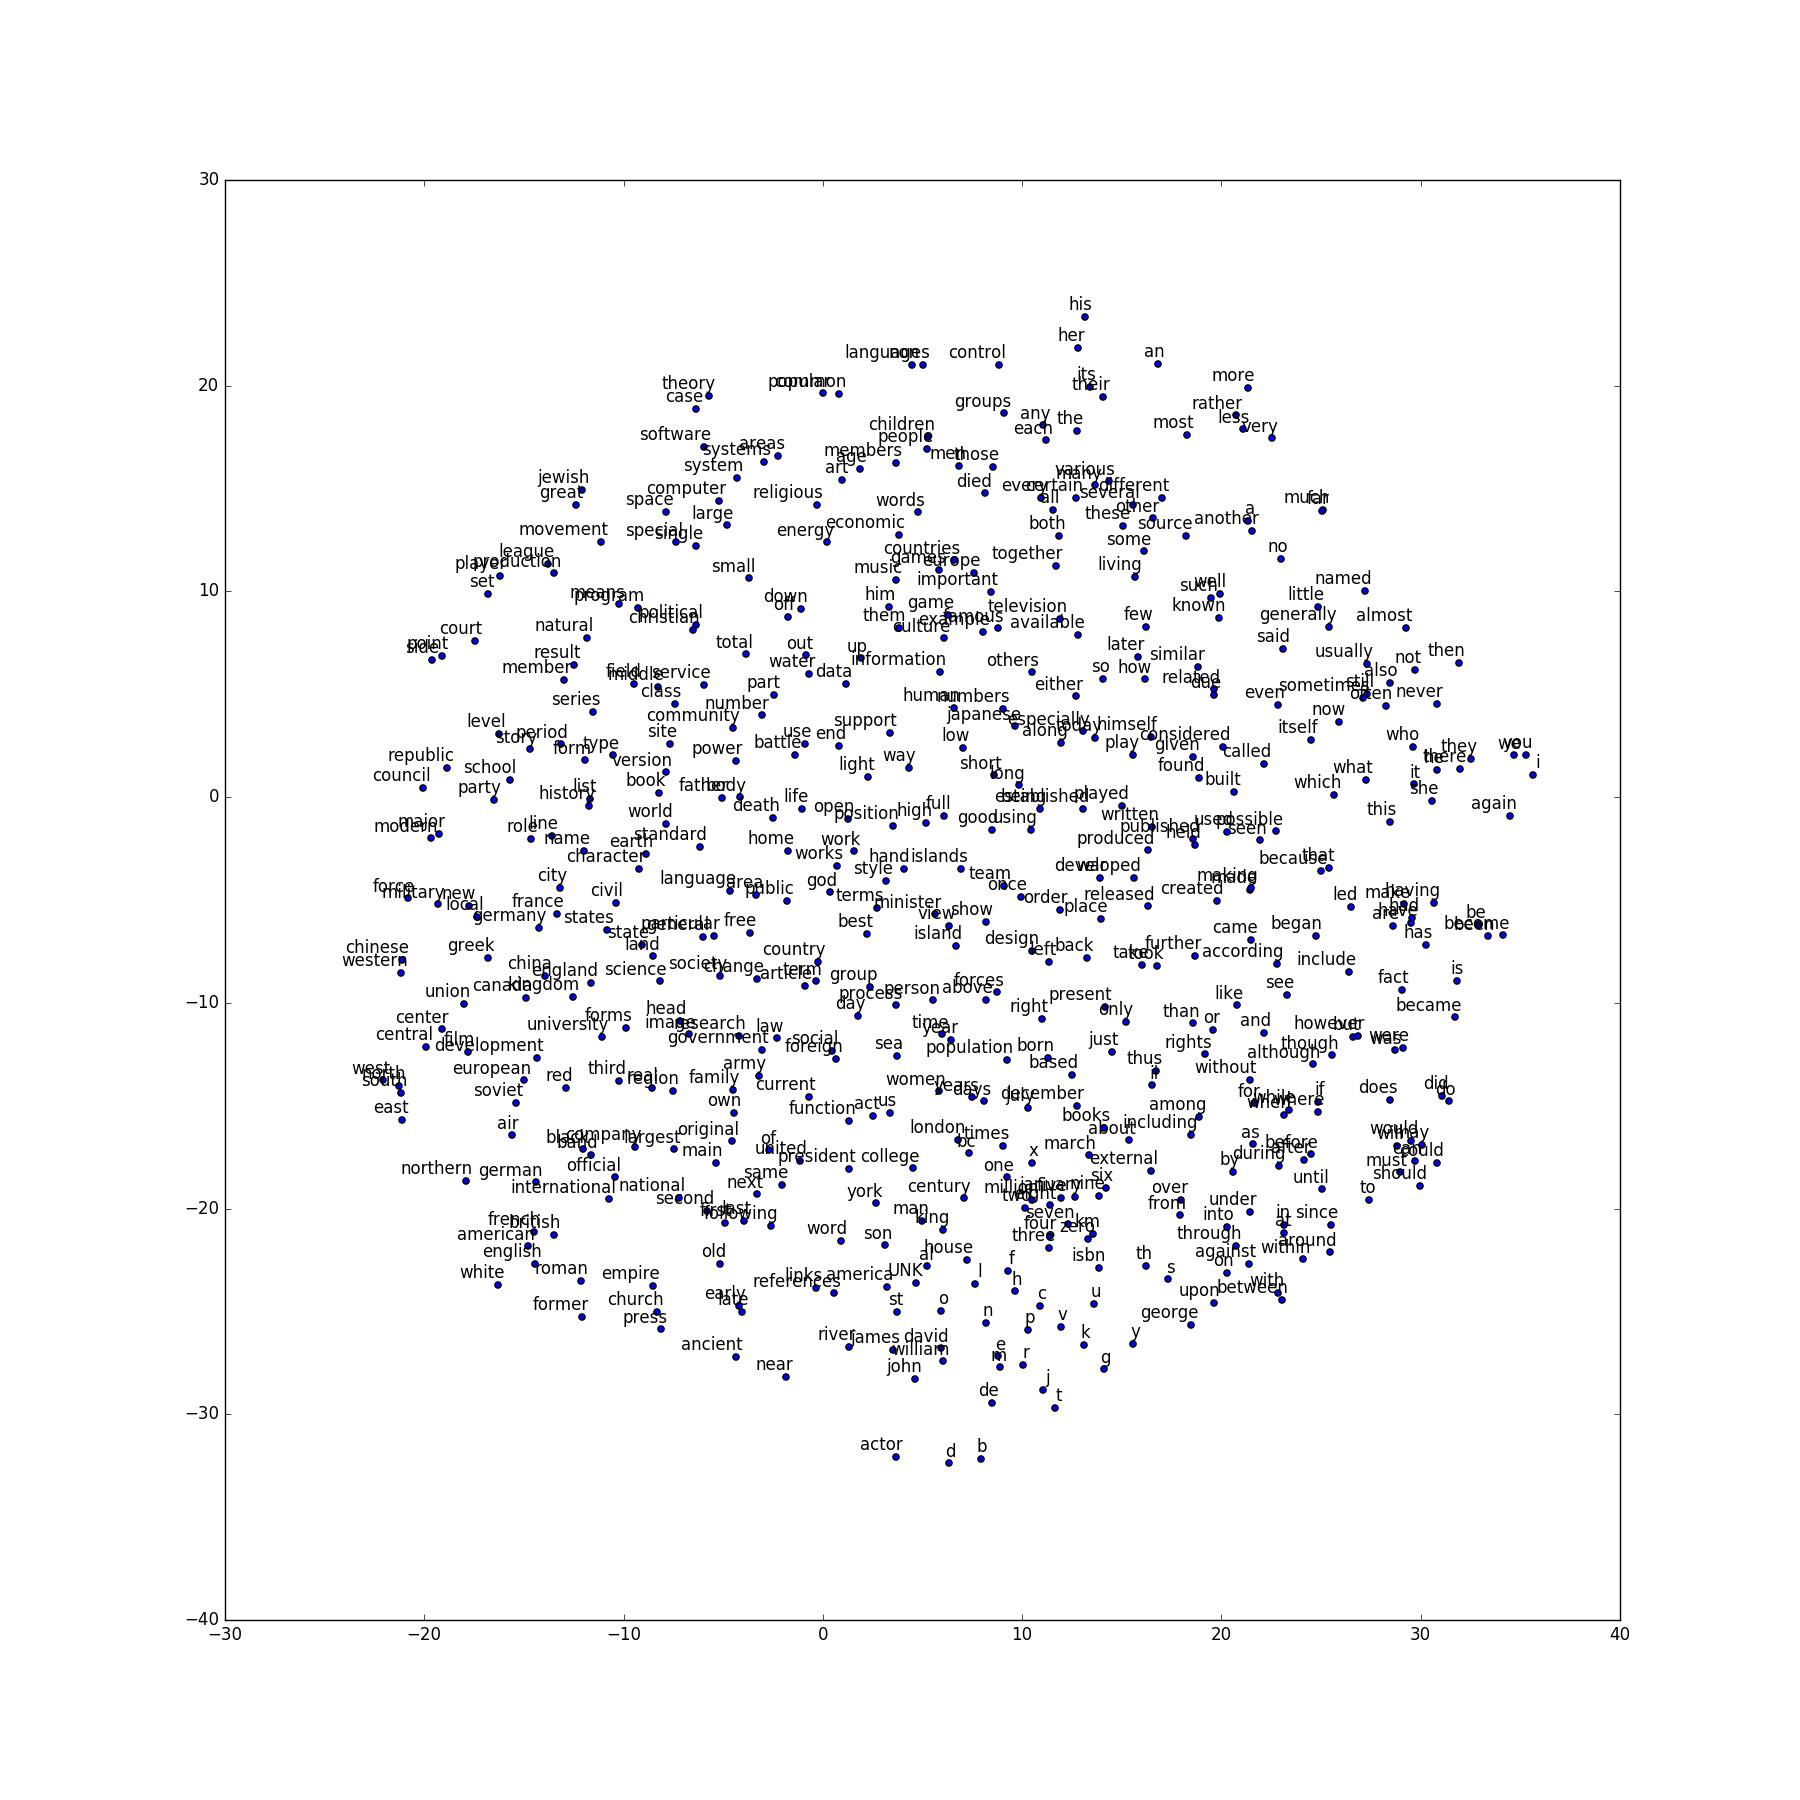

In [186]:
from IPython.display import Image
#from IPython.core.display import HTML 
#Image(url=/Users/yuxuanzhang/tsne.pngsne.png")
Image(filename='tsne.png')